In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib, json
%matplotlib notebook

In [141]:
api_key = '67e4d2db664b1b1ebdc4dba1c052b1f8' #Brian's EIA API key
def get_hourly_load_by_region(region, utc=False, year=None):
    '''
    Get the hourly load data from EIA form 930, given an allowed region specifier from the EIA API
    
    Arguments:
    ----------
    region: A string specifying a grid region or balancing authority used in EIA form 930. 
            Examples include 'CAL', 'SW', 'ERCO', 'ISNE', etc. 
            All allowed specifiers are the codes in parentheses on this page: 
            https://www.eia.gov/opendata/qb.php?category=2122628
            
    Keyword Arguments:
    ------------------
    utc: If True, return time in UTC. Otherwise use local time.
    year: If specified, return only data within the given year (currently available for 2015-present)
    '''
    local=''
    if not utc:
        local='L'
    url = 'http://api.eia.gov/series/?api_key={k}&series_id=EBA.{r}-ALL.D.H{l}'.format(k=api_key,
                                                                                       r=region, 
                                                                                       l=local)
    with urllib.request.urlopen(url) as response:
       res = response.read()
    data = pd.DataFrame(json.loads(res)['series'][0]['data'], columns=['timestamp', 'demand'])
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data = data.sort_values('timestamp').reset_index()
    
    #Extract date components
    #Have to do this in a loop because of an apparent bug in pandas datetime functionality with non-UTC timestamps
    data['year']=0
    data['month']=0
    data['mday']=0
    data['yday']=0
    data['wday']=0
    data['hour_ending']=0
    
    for i, r in data.iterrows():
        tt = r['timestamp'].timetuple()
        data.at[i,'year'] = tt.tm_year
        data.at[i,'month'] = tt.tm_mon
        data.at[i,'mday'] = tt.tm_mday
        data.at[i,'yday'] = tt.tm_yday
        data.at[i,'wday'] = tt.tm_wday
        data.at[i,'hour_ending'] = tt.tm_hour+1
    
    if year:
        data=data.loc[data['year']==year].reset_index()
        
    return data
    
    
    
    
    

In [171]:
cal = get_hourly_load_by_region('CAL', year=2017, utc=False)
cal

level_0  index                  timestamp  demand  year  month  mday  \
0       13200  25672  2017-01-01 00:00:00-08:00   28627  2017      1     1   
1       13201  25671  2017-01-01 01:00:00-08:00   27373  2017      1     1   
2       13202  25670  2017-01-01 02:00:00-08:00   26214  2017      1     1   
3       13203  25669  2017-01-01 03:00:00-08:00   25327  2017      1     1   
4       13204  25668  2017-01-01 04:00:00-08:00   24752  2017      1     1   
...       ...    ...                        ...     ...   ...    ...   ...   
8755    21955  16917  2017-12-31 19:00:00-08:00   32629  2017     12    31   
8756    21956  16916  2017-12-31 20:00:00-08:00   31700  2017     12    31   
8757    21957  16915  2017-12-31 21:00:00-08:00   30698  2017     12    31   
8758    21958  16914  2017-12-31 22:00:00-08:00   29584  2017     12    31   
8759    21959  16913  2017-12-31 23:00:00-08:00   28389  2017     12    31   

      yday  wday  hour_ending  
0        1     6            1  
1        1     6            2  
2        1     6            3  
3        1     6            4  
4        1     6            5  
...    ...   ...          ...  
8755   365     6           20  
8756   365     6           21  
8757   365     6           22  
8758   365     6           23  
8759   365     6           24  

[8760 rows x 10 columns]

<IPython.core.display.Javascript object>


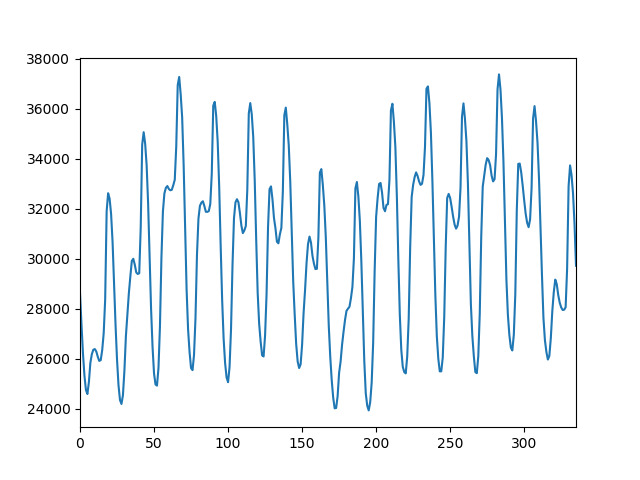

In [174]:
plt.figure()
cal.loc[(cal['month']==1)&(cal['mday']<15),'demand'].plot()

In [158]:
#Check: TEX and ERCO should be the same
tex=get_hourly_load_by_region('TEX', year=2017)
erco = get_hourly_load_by_region('ERCO', year=2017)
(tex['demand']-erco['demand']).sum()

0.0

In [175]:
#Check: NE and ISNE should be the same
ne=get_hourly_load_by_region('NE', year=2017)
isne = get_hourly_load_by_region('ISNE', year=2017)
(ne['demand']-isne['demand']).sum()

0.0

In [180]:
#Construct CAMX: This should be CAL minus IID (Imperial Irrigation Dist)
camx = cal.copy() 
camx['demand'] = cal['demand'] - get_hourly_load_by_region('IID', year=2017)['demand'].fillna(0)

<IPython.core.display.Javascript object>


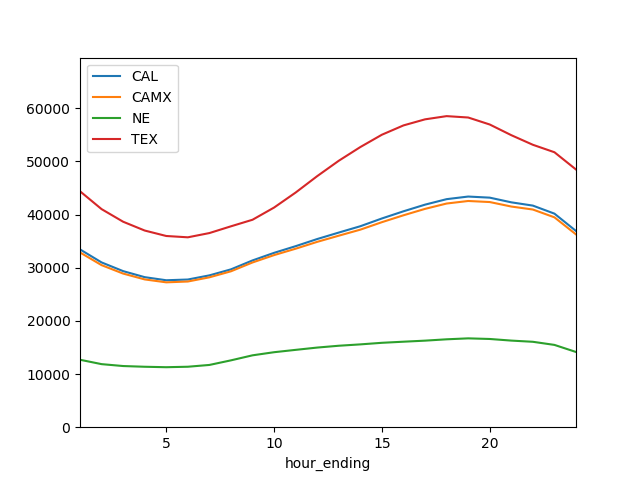

In [197]:
#Plot average daily load shapes for a given month
month=6
plt.figure()
ax=cal.loc[cal['month']==month].groupby('hour_ending').mean()['demand'].plot(label='CAL')
camx.loc[camx['month']==month].groupby('hour_ending').mean()['demand'].plot(label='CAMX',ax=ax)
ne.loc[ne['month']==month].groupby('hour_ending').mean()['demand'].plot(label='NE',ax=ax)
tex.loc[tex['month']==month].groupby('hour_ending').mean()['demand'].plot(label='TEX',ax=ax)
ax.set_ylim([0,max(tex['demand'])])
ax.legend()


In [178]:
cal['demand']-camx['demand']

0         0.0
1       259.0
2       255.0
3       238.0
4       240.0
        ...  
8755      NaN
8756      NaN
8757      NaN
8758      NaN
8759      NaN
Name: demand, Length: 8760, dtype: float64

In [179]:
camx['demand']

0       28627.0
1       27114.0
2       25959.0
3       25089.0
4       24512.0
         ...   
8755        NaN
8756        NaN
8757        NaN
8758        NaN
8759        NaN
Name: demand, Length: 8760, dtype: float64